<a href="https://colab.research.google.com/github/Aleman778/Deep-Learning/blob/master/project/GAN_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional Generative Adversarial Network Experimentation
In this notebook we will experiment with implementing and training a generative adversarial network using a deep convolutional neural network. This experiment is inspired by the [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) and this was made using the following [DCGAN PyTorch tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) which refers to the paper.

## Imports and preparations
Just some standard imports and setting up RNG seed.

In [23]:
import random
import time
import copy
import torch
import torchvision
import torchvision.utils as vutils
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from tqdm import tqdm_notebook
from torch import nn, optim
from torchvision import datasets, transforms

# Make the plots bigger
matplotlib.rcParams['figure.figsize'] = [15, 10]
    
# Setting seed for RNGs (set to constant for reproducability).
manualSeed = 42 # time.time()
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  42


## Define inputs to the network
Tweak these to alter the training process.

In [0]:
# Load a pretrained model
pretrained = False
pretrained_path = "models/best_model.pth.tar"

# Shuffle the contents in the dataset
shuffle = True

# Number of worker threads for dataloader
num_workers = 4

# Size of input images (images are resized to this using transformer)
image_size = 64

# Size of one batch during training
batch_size = 128

# Number of channels in the training images (color RGB uses 3 channels)
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of epochs
num_epochs = 5

# Learning rate for optimizer
lr = 0.0001

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.9

## Setup up the datasets

Files already downloaded and verified
Training on: Tesla P100-PCIE-16GB


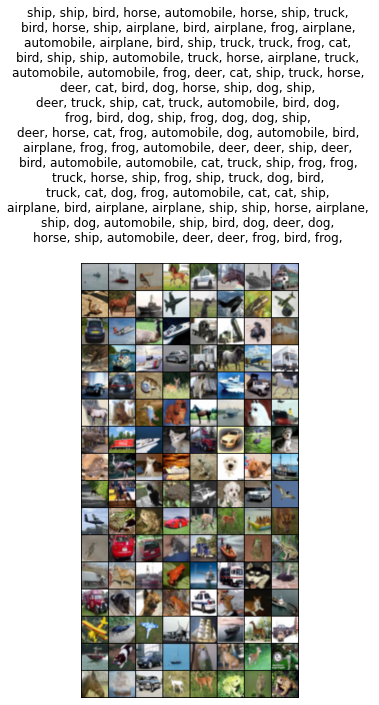

In [9]:
# Data augmentations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5,  0.5), (0.5, 0.5, 0.5))
])

# The dataset directory
data_dir = "data/cifar10/"

# Prepare train dataset
train_dataset = datasets.CIFAR10(data_dir, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size,
                                            shuffle=shuffle,
                                            num_workers=num_workers)

# Prepare test dataset                                         
test_dataset = datasets.CIFAR10(data_dir, train=False, download=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=batch_size,
                                            shuffle=shuffle,
                                            num_workers=num_workers)

# Dataset information
train_size = len(train_loader)
test_size = len(test_loader)
class_names = train_dataset.classes


# Select device to train on, preferred is GPU running on CUDA 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
print("Training on:", device_name)

# Let's print some samples from the dataset
inputs, classes = next(iter(train_loader));
inputs = torchvision.utils.make_grid(inputs, padding=2, normalize=True)
plt.figure(figsize=(12, 8))
plt.axis("off")
plt.imshow(np.transpose(inputs, (1, 2, 0)))
title = ""
for i, x in enumerate(classes):
    title += class_names[x] + ", " 
    if (i % 8) == 7:
        title += "\n"
plt.title(title)
plt.show()
plt.pause(0.001)
print("")

## Setup the model

In [0]:
# From the DCGAN paper the authors specify that all model weights shall be
# randomly initialized from a normal distribution with mean=0 and stdev=0.02.
def init_weights(model):
    classname = model.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)



# Generator model is a Transposed (or fractional-strided) convolutional neural network
#     input: latent vector `Z` of `nz` dimensions
#     output: image that has been generated from input vector
generator_model = nn.Sequential(
    # INPUT - latent vector Z is the input to convolution
    nn.ConvTranspose2d(nz, ngf*8, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(ngf*8),
    nn.ReLU(inplace=True),

    # CONV1 - current dimension is: (ngf) * (image_size/16) * (image_size/16)
    nn.ConvTranspose2d(ngf*8, ngf*4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ngf*4),
    nn.ReLU(inplace=True),

    # CONV2 - current dimension is: (ngf*4) * (image_size/8) * (image_size/8)
    nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ngf*2),
    nn.ReLU(inplace=True),

    # CONV3 - current dimension is: (ngf*2) * (image_size/4) * (image_size/4)
    nn.ConvTranspose2d(ngf*2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ngf),
    nn.ReLU(inplace=True),

    # CONV4 - current dimension is: (ngf) * (image_size/2) * (image_size/2)
    nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()

    # OUTPUT - dimension is: (nc) * image_size * image_size
)


# Send generator model to current device
generator_model.to(device)
generator_model.apply(init_weights)

# Discriminator model is a regular convolutional neural network
#     input: images of one single batch (#images is the batch_size)
#     output: single floating-point between 0.0 (fake) and 1.0 (real)
discriminator_model = nn.Sequential(
    # INPUT - image of dimensions (nc) * image_size * image_size
    nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),

    # CONV1 - current dimension is: (ndf) * (image_size/2) * (image_size/2)
    nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ndf*2),
    nn.LeakyReLU(0.2, inplace=True),

    # CONV2 - current dimension is: (ndf*2) * (image_size/4) * (image_size/4)
    nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ndf*4),
    nn.LeakyReLU(0.2, inplace=True),

    # CONV2 - current dimension is: (ndf*4) * (image_size/8) * (image_size/8)
    nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ndf*8),
    nn.LeakyReLU(0.2, inplace=True),

    # CONV4 - current dimension is: (ndf*8) * (image_size/16) * (image_size/16)
    nn.Conv2d(ndf*8, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Sigmoid()

    # OUTPUT - single number between 0.0 (fake) and 1.0 (real)
)

# Send both models to the selected device
discriminator_model.to(device)
discriminator_model.apply(init_weights)

# Criterion or loss function used
criterion = nn.BCELoss()

# The optimizer for weight updating
g_optimizer = optim.Adam(generator_model.parameters(), lr=lr, betas=(beta1, 0))
d_optimizer = optim.Adam(discriminator_model.parameters(), lr=lr, betas=(beta1, 0))

## Testing the generator before training

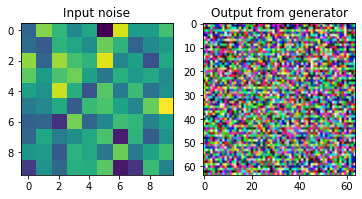

In [17]:
input_noise = torch.randn(1, nz, 1, 1, device=device)

plt.figure(2)
plt.subplot(1, 2, 1)
plt.imshow(input_noise.cpu().numpy().reshape(10, 10))
plt.title("Input noise")

generated_image = generator_model(input_noise)
fake_image = transforms.functional.to_pil_image(generated_image.cpu().view(3, 64, 64))

plt.subplot(1, 2, 2)
plt.imshow(fake_image)
plt.title("Output from generator")
plt.show()

## Utility functions

In [0]:
def draw_plot(data, epoch, title="Training"):
    title = title + " on " + device_name
    plot = alt.Chart(data, width=1200, height=400, title=title).mark_line().encode(
        alt.X("Epoch:Q", scale=alt.Scale(zero=False), axis=alt.Axis(title="Epoch", tickCount=epoch)),
        alt.Y("Value:Q", scale=alt.Scale(zero=False), axis=alt.Axis(title="Value")),
        color=alt.Color("Legend", legend=alt.Legend(title="Value by color")))
    plot.background = "#EFEFEF"
    plot = plot.interactive(bind_y=True)
    plot = plot.configure_view(strokeOpacity=0)
    plot.display()

## Training the model

In [21]:
# Labels is defined as follows
fake_label = 0
real_label = 1

# Store some images during training, to see generator progression.
img_list = []
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Keep track of some running statistics to view after training
g_batch_losses = []
d_batch_losses = []
g_train_losses = []
d_train_losses = []
g_train_accuracies = []
d_train_accuracies = []


for epoch in range(num_epochs):
    epoch_stats = {
        "discriminator_train_loss": 0.0,
        "discriminator_train_corrects": 0.0,
        "generator_train_loss": 0.0,
        "generator_train_corrects": 0.0}

    for batch_num, (real_images, _) in enumerate(train_loader):

        ##############################################################
        # Training Discriminator with REAL (dataset) images
        ##############################################################


        # Reset the discriminator gradients
        discriminator_model.zero_grad()

        # Setup the input data and label
        real_images = real_images.to(device);
        b_size = real_images.size(0)
        label = torch.full((b_size,), real_label, device=device);

        # Forward pass real batch through discriminator
        output = discriminator_model(real_images).view(-1)

        # Define prediction as the rounded value from output
        d_pred_real = output.round()

        # Compute the loss using set criterion
        d_loss_real = criterion(output, label)

        # Calculate the gradients for discriminator in backward pass
        d_loss_real.backward()
        d_x = output.mean().item()


        ##############################################################
        # Training Discriminator with FAKE (generated) images
        ##############################################################


        # Generate batch of latent vectors 
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        # Generate fake image batch using our generator
        fake_images = generator_model(noise)
        label.fill_(fake_label);

        # Make predictions for the batch of fake images using discriminator
        output = discriminator_model(fake_images).view(-1)

        # Define prediction as the rounded value from output
        d_pred_fake = output.round()

        # Compute the loss using set criterion
        d_loss_fake = criterion(output, label)

        # Calculate the gradients for discriminator in backward pass
        d_loss_fake.backward()
        d_g_z1 = output.mean().item()

        # Now update discriminator
        d_optimizer.step()


        # Update statistics
        d_batch_loss = d_loss_real.item()
        d_batch_loss += d_loss_fake.item()
        d_corrects = torch.sum(d_pred_real == 1).item()
        d_corrects = torch.sum(d_pred_fake == 0).item()
        epoch_stats["discriminator_train_loss"] += d_batch_loss
        epoch_stats["discriminator_train_corrects"] += d_corrects


        ##############################################################
        # Training Generator
        ##############################################################


        # Reset the discriminator gradients
        generator_model.zero_grad()
        
        # Generate batch of new latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        # Generate new fake image batch using our generator
        fake_images = generator_model(noise)

        # Since we just updated our discriminator we now want to perform
        # another forward pass of the batch of fake images trough our discriminator
        output = discriminator_model(fake_images).view(-1)

        # When training the generator we want the discriminator to think our fake images are real
        label.fill_(real_label);

        # Compute the loss using set criterion
        g_loss = criterion(output, label)

        # Define prediction as the rounded value from output
        g_pred = output.round()

        # Calcualte gradients for the generator
        g_loss.backward()
        d_g_z2 = output.mean().item()

        # Now update generator
        g_optimizer.step()

        # Update statistics
        g_batch_loss = g_loss.item()
        g_corrects = torch.sum(g_pred == 1).item()
        epoch_stats["generator_train_loss"] += g_batch_loss
        epoch_stats["generator_train_corrects"] += g_corrects

        # Print batch stats
        if batch_num % 50 == 0:
            print("[{}/{}][{}/{}]\t[D loss: {:.4f}]\t[G loss: {:.4f}]\tD(x):{:.4f}\tD(G(z)):{:.4f}/{:.4f}".format(
                epoch+1, 
                num_epochs,
                batch_num + 1,
                train_size + 1,
                d_batch_loss,
                g_batch_loss,
                d_x, d_g_z1, d_g_z2
        ))

        # Save batch losses plotting later
        d_batch_losses.append(d_batch_loss)
        g_batch_losses.append(g_batch_loss)


        # Check the progress of the generator by saving its output on fixed_noise
        if (batch_num % 500 == 0) or ((epoch == num_epochs - 1) and (batch_num == train_size - 1)):
            with torch.no_grad():
                fake_img = generator_model(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_img, padding=2, normalize=True))

    # After finishing an epoch print the epoch stats
    print("Epoch {}/{}: \t[D loss: {:.4f}, acc.:{:.4f}]\t[G loss: {:.4f}, acc.:{:.4f}]".format(
        epoch+1, 
        num_epochs,
        batch_num + 1,
        train_size + 1,
        epoch_stats["discriminator_train_loss"]/train_size,
        epoch_stats["discriminator_train_corrects"]/train_size,
        epoch_stats["generator_train_loss"]/train_size,
        epoch_stats["generator_train_corrects"]/train_size))

    # Save epoch stats for plotting later
    d_train_losses.append(epoch_stats["discriminator_train_loss"]/train_size)
    d_train_accuracies.append(epoch_stats["discriminator_train_corrects"]/train_size)
    g_train_losses.append(epoch_stats["generator_train_loss"]/train_size)
    g_train_accuracies.append(epoch_stats["generator_train_corrects"]/train_size)

[1/1][1/392]	[D loss: 1.1127]	[G loss: 1.9112]	D(x):0.6863	D(G(z)):0.4423/0.3640
[1/1][51/392]	[D loss: 1.8900]	[G loss: 3.6167]	D(x):0.9161	D(G(z)):0.5366/0.1101
[1/1][101/392]	[D loss: 57.8125]	[G loss: 100.0000]	D(x):0.4219	D(G(z)):0.0000/0.0000
[1/1][151/392]	[D loss: 58.5938]	[G loss: 100.0000]	D(x):0.4141	D(G(z)):0.0000/0.0000
[1/1][201/392]	[D loss: 58.5938]	[G loss: 100.0000]	D(x):0.4141	D(G(z)):0.0000/0.0000
[1/1][251/392]	[D loss: 57.8125]	[G loss: 100.0000]	D(x):0.4219	D(G(z)):0.0000/0.0000
[1/1][301/392]	[D loss: 58.5938]	[G loss: 100.0000]	D(x):0.4141	D(G(z)):0.0000/0.0000
[1/1][351/392]	[D loss: 62.5000]	[G loss: 100.0000]	D(x):0.3750	D(G(z)):0.0000/0.0000
Epoch 1/1: 	[D loss: 391.0000, acc.:392.0000]	[G loss: 48.4213, acc.:116.9591]


## Plotting the Results

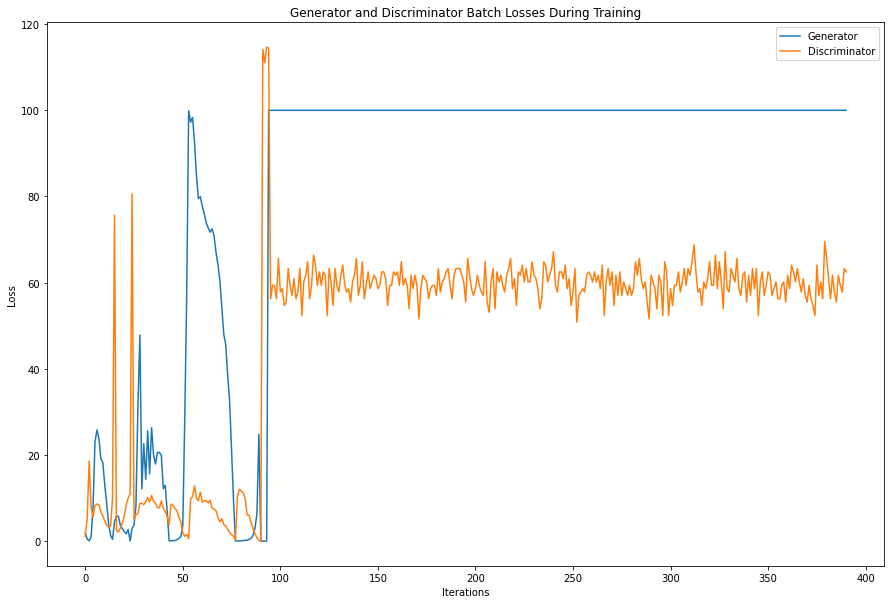

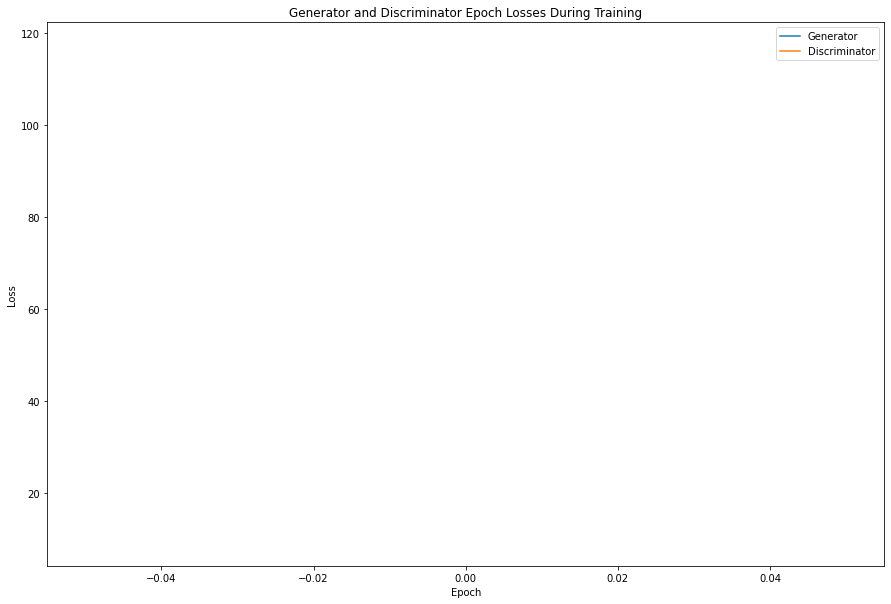

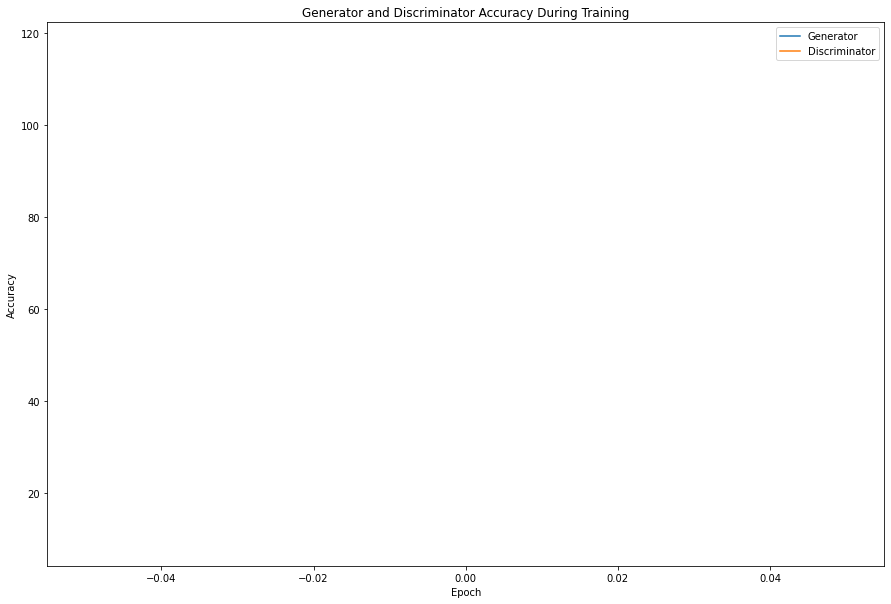

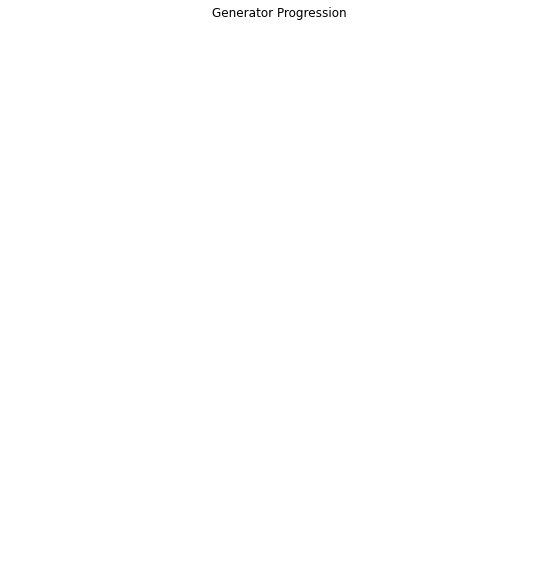

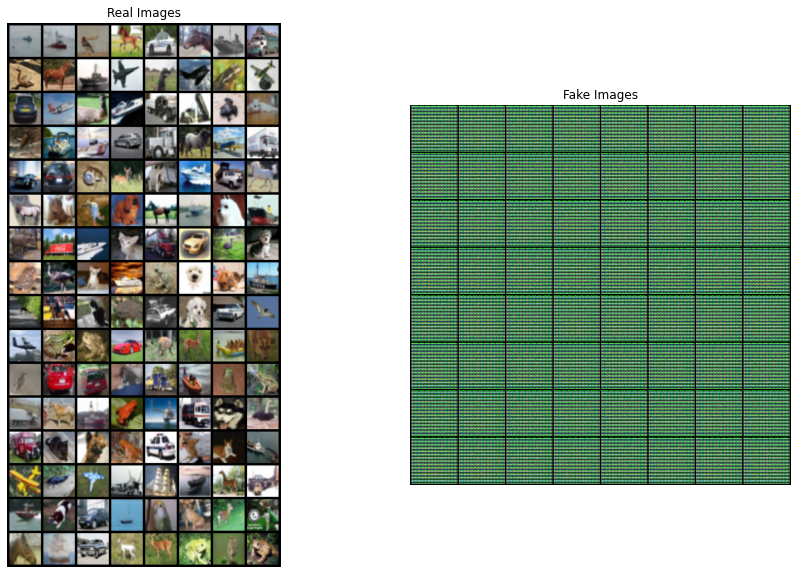

In [24]:
plt.figure(3)
plt.title("Generator and Discriminator Batch Losses During Training")
plt.plot(g_batch_losses, label="Generator")
plt.plot(d_batch_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.figure(4)
plt.title("Generator and Discriminator Epoch Losses During Training")
plt.plot(g_train_accuracies, label="Generator")
plt.plot(d_train_accuracies, label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.figure(5)
plt.title("Generator and Discriminator Accuracy During Training")
plt.plot(g_train_accuracies, label="Generator")
plt.plot(d_train_accuracies, label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Visualziation of generators progression
fig = plt.figure(6)
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
plt.title("Generator Progression")

# Grab a batch of real images from the datset
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(7)
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0], padding=5, normalize=True), (1, 2, 0)))

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))

plt.show()